(e_raster_reproject)=

----------------

```{admonition} Learning Objectives
- Resample a raster with rasterio & geowombat
- Learn how to match the extent
```
```{admonition} Review
* [Affine transformation](d_affine)
* [Raster Coordinate Reference Systems](d_raster_crs_intro)
* [Reprojecting Rasters](e_raster_reproject.md)
* [Interpolation Methods Explained](d_raster_crs_intro_interpolation_options)
```
----------------

# Resampling & Registering Rasters w. Rasterio and Geowombat

## Why is Resampling Important?
*Before you begin* any analysis using rater data it is critical that you have rasters that are "co-registered". Co-registration requires that any two rasters have the same resolution, and orientation - the origins can differ but they much align. *In other words, co-registration requires that cell centroids align perfectly for all intersecting areas.* Resampling is also extremely common during reprojection operations as it often requires changing the orientation, scale or resolution of an image. 

**Examples of data that is *not* co-registered**

```{figure} ../_static/e_raster/Raster_diff-orientation.jpg
:name: Resampling rasters - different orientation
:width: 400px
Resampling rasters - different orientation
```

```{figure} ../_static/e_raster/Raster_diff-orientation-origin.jpg
:name: Resampling rasters - different orientation and origin
:width: 400px
Resampling rasters - different orientation and origin
```
```{figure} ../_static/e_raster/Raster_diff-res.jpg
:name: Resampling rasters - different resolution
:width: 400px
Resampling rasters - different resolution
```
We can co-register images by resampling, and often reprojecting, one image to match another. 

(raster_resample_methods)=
## Methods for Resampling Explained
There are [a number of methods](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling) to resample data, but they often take the form of "nearest neighbor", "bilinear", and "cubic convolusion" - these interpolation methods [are explained here in some detail](d_raster_crs_intro_interpolation_options.md). But there are a number of other including: [‘average’, ‘cubic_spline’, ‘gauss’, ‘lanczos’, ‘max’, ‘med’, ‘min’, ‘mode’, ‘nearest’]. 

**resampling direction**
- Upsampling - converting to higher resolution/smaller cells. 
- Downsampling - converting to lower resolution/larger cell sizes.


## Simple Up/Downsampling in Rasterio & Geowombat
### Rasterio Upsampling Example
Occationally you will need to resample your data by some factor, for instance you might want data upsampled to a courser resolution due to memory constraints. 


Here's an example of how to generate the `data` array and the `transform` needed to write it out. We will start by simply reading in the data and coersing a higher resolution, by adding more rows and columns. To understand the `transform`, let's review [affine transformations](d_affine). Here we will update the scale values with the new resolution using $S_{y}$ and $S_{x}$ show below

$$
   \begin{eqnarray}
   \mbox{Scale transform: }  \begin{bmatrix} S_{x} & 0 & 0 \\ 0 & S_{y} & 0 \\ 0 & 0 & 1 \end{bmatrix} 
   \end{eqnarray}
$$

In [1]:
import rasterio
from rasterio.enums import Resampling

image = "../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

upscale_factor = 2

with rasterio.open(image) as dataset:

    # resample data to target shape using upscale_factor
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    print('Shape before resample:', dataset.shape)
    print('Shape after resample:', data.shape[1:])

    # scale image transform
    dst_transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    print('Transform before resample:\n', dataset.transform, '\n')
    print('Transform after resample:\n', dst_transform)

    ## Write outputs
    # set properties for output
    # dst_kwargs = src.meta.copy()
    # dst_kwargs.update(
    #     {
    #         "crs": dst_crs,
    #         "transform": dst_transform,
    #         "width": data.shape[-1],
    #         "height": data.shape[-2],
    #         "nodata": 0,  
    #     }
    # )

    # with rasterio.open("../temp/LC08_20200518_15m.tif", "w", **dst_kwargs) as dst:
    #     # iterate through bands
    #     for i in range(data.shape[0]):
    #           dst.write(data[i].astype(rasterio.uint32), i+1)

Shape before resample: (1860, 2041)
Shape after resample: (3720, 4082)
Transform before resample:
 | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00| 

Transform after resample:
 | 15.00, 0.00, 717345.00|
| 0.00,-15.00,-2776995.00|
| 0.00, 0.00, 1.00|


```{admonition} Reminder
Read up on [affine transformations](d_affine_transform_matrix) to help you understand the `transform.scale` function above. 
```

### Geowombat Up/Down Sampling Example
As always the easiest way to deal with resampling is by deploying geowombat. It's like a swiss army knife for kicking raster butt. Here we just need to set the desired resolution with `ref_res`, and the `resampling` method in the open statement. We have a number of resampling methods available depending on the context [listed above](raster_resample_methods). Writing a file is a bit more intuitive too.

In [2]:
import geowombat as gw
 
image = "../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"

with gw.config.update(ref_res=15):
    with gw.open(image, resampling="bilinear") as src:
        print(src)
        
        # to write out simply:
        # src.gw.to_raster(
        #     "../temp/LC08_20200518_15m.tif",
        #     overwrite=True,
        # ) 

<xarray.DataArray (band: 3, y: 3720, x: 4082)>
dask.array<open_rasterio-5d3779c5d83524d14a4bbcf537a1f23d<this-array>, shape=(3, 3720, 4082), dtype=uint16, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * x        (x) float64 7.174e+05 7.174e+05 7.174e+05 ... 7.786e+05 7.786e+05
Attributes:
    transform:          (15.0, 0.0, 717345.0, 0.0, -15.0, -2776995.0)
    crs:                +init=epsg:32621
    res:                (15.0, 15.0)
    is_tiled:           1
    nodatavals:         (0, 0, 0)
    scales:             (1.0, 1.0, 1.0)
    offsets:            (0.0, 0.0, 0.0)
    filename:           ../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF
    resampling:         bilinear
    AREA_OR_POINT:      Area
    data_are_separate:  0
    data_are_stacked:   0


Much.... easier.... 


## Co-registering Rasters (Aligning cells)
One common problem is how to get raster data to align on a cell by cell basis so you can complete your analysis. We will walk through how to do this for both rasterio and geowombat. In the following example we will learn how to align rasters with different origins, resolutions, or orientations. 

Our example data will look at registering LandSat data with precipitation data from CHIRPS. 

### Example of Co-registering Rasters with Rasterio
Co-registering data is a bit complicated with rasterio, you simply need to choose an "reference image" to match the bounds, CRS, and cell size. 

The original input data LandSat data is 30 meters and will be downsampled to match `precip` which is 500m.  Also note the use of `nodata` to avoid missing values stored as 0. Note we can choose a number of `resampling` techniques [listed above](raster_resample_methods). For more detail on resampling go to [Introduction to Raster CRS](d_raster_crs_intro).

In [3]:
from rasterio.warp import reproject, Resampling, calculate_default_transform
import rasterio
def reproj_match(infile, match, outfile):
    """Reproject a file to match the shape and projection of existing raster. 
    
    Parameters
    ----------
    infile : (string) path to input file to reproject
    match : (string) path to raster with desired shape and projection 
    outfile : (string) path to output file tif
    """
    # open input
    with rasterio.open(infile) as src:
        src_transform = src.transform
        
        # open input to match
        with rasterio.open(match) as match:
            dst_crs = match.crs
            
            # calculate the output transform matrix
            dst_transform, dst_width, dst_height = calculate_default_transform(
                src.crs,     # input CRS
                dst_crs,     # output CRS
                match.width,   # input width
                match.height,  # input height 
                *match.bounds,  # unpacks input outer boundaries (left, bottom, right, top)
            )

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update({"crs": dst_crs,
                           "transform": dst_transform,
                           "width": dst_width,
                           "height": dst_height,
                           "nodata": 0})
        print("Coregistered to shape:", dst_height,dst_width,'\n Affine',dst_transform)
        # open output
        with rasterio.open(outfile, "w", **dst_kwargs) as dst:
            # iterate through bands and write using reproject function
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)


Now we can execute out code to co-register two rasters

In [4]:
LS = "../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
precip = "../data/precipitation_20200601_500m.tif"

# co-register LS to match precip raster
reproj_match(infile = LS, 
             match= precip,
             outfile = '../temp/LS_reg_precip.tif')

Coregistered to shape: 136 157 
 Affine | 0.00, 0.00,-61.49|
| 0.00,-0.00,-0.00|
| 0.00, 0.00, 1.00|


### Example of Co-registering Rasters with Geowombat
Co-registering data is simple in geowombat, you simply need to choose an "reference image" to match the bounds, CRS, and cell size. 

The original input data `precip` is currently 500m but will be upsampled to 30m as seen in `print(src)`.  Also note the use of `nodata` to avoid missing values stored as -9999. Note we can choose a number of `resampling` techniques [listed above](raster_resample_methods). For more detail on resampling go to [Introduction to Raster CRS](d_raster_crs_intro).

<xarray.DataArray (band: 1, y: 1860, x: 2041)>
dask.array<open_rasterio-5ea1b887333ee835e34ed81f251d6116<this-array>, shape=(1, 1860, 2041), dtype=float32, chunksize=(1, 135, 157), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 -2.777e+06 -2.777e+06 ... -2.833e+06 -2.833e+06
  * x        (x) float64 7.174e+05 7.174e+05 7.174e+05 ... 7.785e+05 7.786e+05
Attributes: (12/13)
    transform:          (30.0, 0.0, 717345.0, 0.0, -30.0, -2776995.0)
    crs:                +init=epsg:32621
    res:                (30.0, 30.0)
    is_tiled:           1
    nodatavals:         (0,)
    scales:             (1.0,)
    ...                 ...
    descriptions:       ('precipitation',)
    filename:           ../data/precipitation_20200601_500m.tif
    resampling:         bilinear
    AREA_OR_POINT:      Area
    data_are_separate:  0
    data_are_stacked:   0


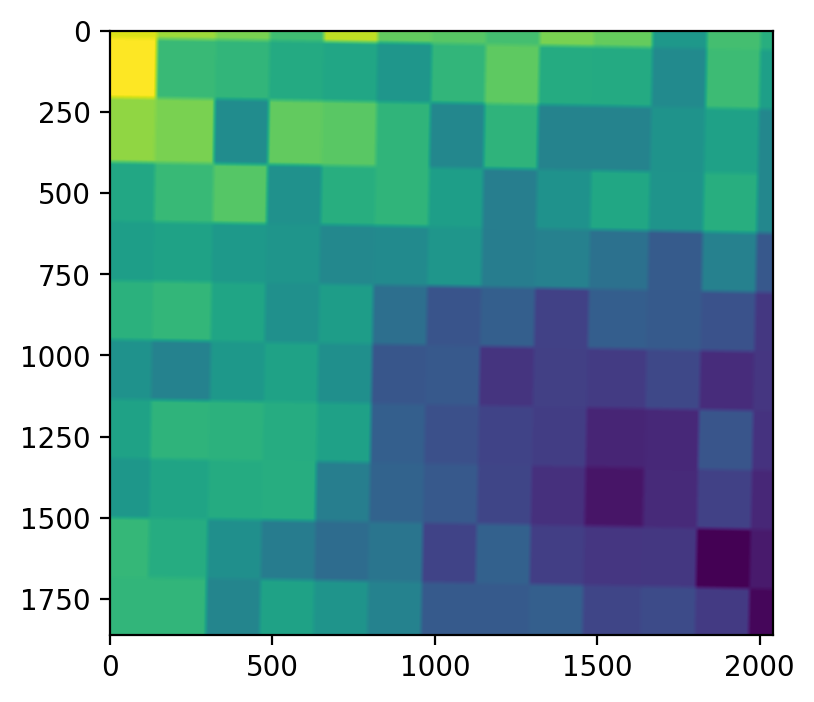

In [5]:
import geowombat as gw
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=200)


LS = "../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF"
precip = "../data/precipitation_20200601_500m.tif"

with gw.config.update(ref_image=LS):
    with gw.open(precip, resampling="bilinear", nodata=-9999) as src:
        print(src)
        ax.imshow(src.data[0])
        
        # to write out simply:
        # src.gw.to_raster(
        #     "../temp/precip_20200601_30m.tif",
        #     overwrite=True,
        # ) 

Although it's a bit hard to tell, the cell size is now 30m (see the slices of the larger original cells at the top of the image).

```{admonition} Note
Also note that geowombat's built in `.imshow` functionality doesn't currently work for single band images. To get an image we have to extract a `np.ndarray` that has the shape `(1, 1860, 2041)`. Where `(1,.,.)` is the band, so to get a 2d array we select `data[0]`. We also avoid missing values (-9999).
```